In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_path = '../Ruda/Ruda-VariableFont_wght.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

# Modelagem do crescimento de BL21 num biorreator com glicose
_Omitindo a fase de declínio_ 

In [2]:
cores = ['#1b6872', '#df208a', '#efb475', '#aec5fb', '#D5A6E6', '#A4D4B4', '#FFD166', '#FF6F61']

Tempo de indução: 1.04 horas

Quantidade total de proteína produzida: 0.6814 g/L
Quantidade de proteína após purificação inicial: 0.6132 g/L
Número de ciclos necessários na cromatografia de afinidade: 13.0
Tempo total de cromatografia de afinidade: 13.0 horas
Eficiência total de purificação: 63.50%
Quantidade final de proteína purificada: 0.3894 g/L


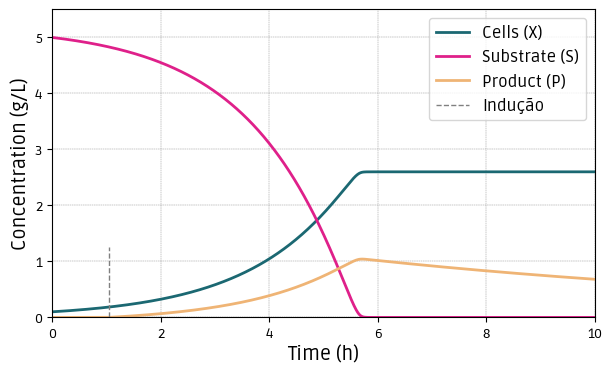

In [28]:
######################## Constantes
mu_max = 0.6        # Taxa de crescimento máxima (h^-1) (E. coli BL21)
K_s = 0.1           # Constante de saturação de substrato (g/L) (para glicose)
Y_x_s = 0.5         # Rendimento celular (g células / g substrato) (glicose)
Y_p_x = 0.5         # Rendimento de proteína (g proteína / g células) (DEPENDE DA PROTEÍNA)
S0 = 5              # Concentração inicial de substrato (g/L) (glicose)
X0 = 0.1            # Concentração inicial de células (g/L) (valor baixo)
P0 = 0              # Concentração inicial de proteína (g/L) (iniciamos sem proteínas formados)
X_inducao = 0.184   # g/L, concentração de bactérias, correspondendo a OD600 = 0.8
k_deg = 0.1         # Taxa de degradação da proteína (h^-1)
#########################

def monod_model(y, t, mu_max, K_s, Y_x_s, Y_p_x, X_inducao, k_deg):
    X, S, P = y
    mu = mu_max * S / (K_s + S)
    dXdt = mu * X
    dSdt = -(1 / Y_x_s) * dXdt
    if X >= X_inducao:
        dPdt = Y_p_x * dXdt - k_deg * P
    else:
        dPdt = -k_deg * P
    return [dXdt, dSdt, dPdt]

y0 = [X0, S0, P0]  # Condições iniciais

t = np.linspace(0, 10, 1000)  # Simular por 10 horas

solution = odeint(monod_model, y0, t, args=(mu_max, K_s, Y_x_s, Y_p_x, X_inducao, k_deg))
X, S, P = solution.T

# Calcular OD600 ao longo do tempo
OD600 = X / 0.23 # REFERENCIA [1]

# Identificar o tempo de indução
indice_inducao = np.argmax(X >= X_inducao)
tempo_inducao = t[indice_inducao]
print(f"Tempo de indução: {tempo_inducao:.2f} horas\n")

######### EFICIENCIA (purificação inicial e recuperação do biorreator)
eficiencia_purificacao = 0.9  # 90% de recuperação

# Quantidade final de proteína produzida (g/L)
P_final = P[-1]

# Quantidade de proteína pura após purificação inicial (g/L)
P_puro = P_final * eficiencia_purificacao

print(f"Quantidade total de proteína produzida: {P_final:.4f} g/L")
print(f"Quantidade de proteína após purificação inicial: {P_puro:.4f} g/L")

# ------------------ Etapas de Purificação ------------------

# 1. Clarificação do Lisado
perda_clarificacao = 0.02  # 2% de perda
P_apos_clarificacao = P_puro * (1 - perda_clarificacao)

# 2. Cromatografia de Afinidade
############## Constantes
Q = 10     # Capacidade de ligação da resina (mg/mL resina)
V_resina = 5  # Volume de resina (mL)
E_rec_afinidade = 0.9  # 90% de recuperação
T_por_ciclo = 1  # Tempo por ciclo (horas)

V_lisado = 1  # Supondo 1 L de lisado

P_total_mg = P_apos_clarificacao * V_lisado * 1000  # L para mL

C_total = Q * V_resina # Capacidade total da coluna (mg)

N_ciclos = np.ceil(P_total_mg / C_total) # Número de ciclos necessários

T_total = N_ciclos * T_por_ciclo # Tempo total de purificação

print(f"Número de ciclos necessários na cromatografia de afinidade: {N_ciclos}")
print(f"Tempo total de cromatografia de afinidade: {T_total} horas")

P_apos_afinidade = P_apos_clarificacao * E_rec_afinidade # Proteína dps da cromatografia de afinidade

# 3. Cromatografia de Troca Iônica
################
E_rec_troca_ionica = 0.8  # 80% de recuperação
P_apos_troca_ionica = P_apos_afinidade * E_rec_troca_ionica

# 4. Filtração em Gel
################
E_rec_filtracao_gel = 0.9  # 90% de recuperação
P_final_purificada = P_apos_troca_ionica * E_rec_filtracao_gel

eficiencia_total_purificacao = (1 - perda_clarificacao) * E_rec_afinidade * E_rec_troca_ionica * E_rec_filtracao_gel

print(f"Eficiência total de purificação: {eficiencia_total_purificacao*100:.2f}%")
print(f"Quantidade final de proteína purificada: {P_final_purificada:.4f} g/L")



# Plot
plt.figure(figsize=(7, 4))
plt.plot(t, X, label='Cells (X)', color=cores[0], lw=2)
plt.plot(t, S, label='Substrate (S)', color=cores[1], lw=2)
plt.plot(t, P, label='Product (P)', color=cores[2], lw=2)

plt.axvline(x=tempo_inducao, ymin=0, ymax=0.228, color='grey', linestyle='--', label='Indução', lw=1)
plt.xlabel('Time (h)', fontsize=14)
plt.ylabel('Concentration (g/L)', fontsize=14)
# plt.title('Crescimento Bacteriano e Produção de Proteínas', fontsize=16)
plt.xticks()
plt.yticks()
plt.legend(fontsize=12)

plt.xlim(0,10)
plt.ylim(0,5.5)

plt.grid(True, linestyle='--', linewidth=0.3, color='gray', alpha=1)

plt.savefig("Price_modeling.png", dpi=500, bbox_inches='tight', transparent=True)

plt.show()

# Modelagem de custo

In [5]:
########## INSUMOS
precos = {
    'plasmideo': 0,               # podemos desconsiderar pq só é comprado uma vez
    'celulas_competentes': 100,   
    'meio_LB': 100,               
    'antibiotico': 100,           
    'glicose': 100,               
    'IPTG': 100,                  
    'coquetel_enzimas': 100,      
    'resina_afinidade': 100,      
    'tampoes_cromatografia': 100, 
    'filtros': 100,               
}

# Referências

[1] https://www.tipbiosystems.com/wp-content/uploads/2023/12/AN102-E.coli-Cell-Count_2019_04_25.pdf -> X_inducao = 0.184 (OS600 = 1 | 0.23 mg/mL)

[2] 